In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score


import warnings
warnings.filterwarnings("ignore")

In [6]:
credit = pd.read_csv('D:/PyCharm Community Edition 2023.1.2/Python_Project/Professional/ML4FRM/german_credit_data.csv')
print(credit.head())
del credit['Unnamed: 0']
print(credit.describe())

   Unnamed: 0  Age     Sex                    Job Housing Saving accounts  \
0           0   67    male                skilled     own             NaN   
1           1   22  female                skilled     own          little   
2           2   49    male  unskilled and residen     own          little   
3           3   45    male                skilled    free          little   
4           4   53    male                skilled    free          little   

  Checking account  Credit amount  Duration              Purpose  Risk  
0           little           1169         6             radio/TV  good  
1         moderate           5951        48             radio/TV   bad  
2              NaN           2096        12            education  good  
3           little           7882        42  furniture/equipment  good  
4           little           4870        24                  car   bad  
               Age  Credit amount     Duration
count  1000.000000    1000.000000  1000.000000
mean 

## Data conversion
#### standard scale for numerical data
#### transform non-numerical into dummy variables

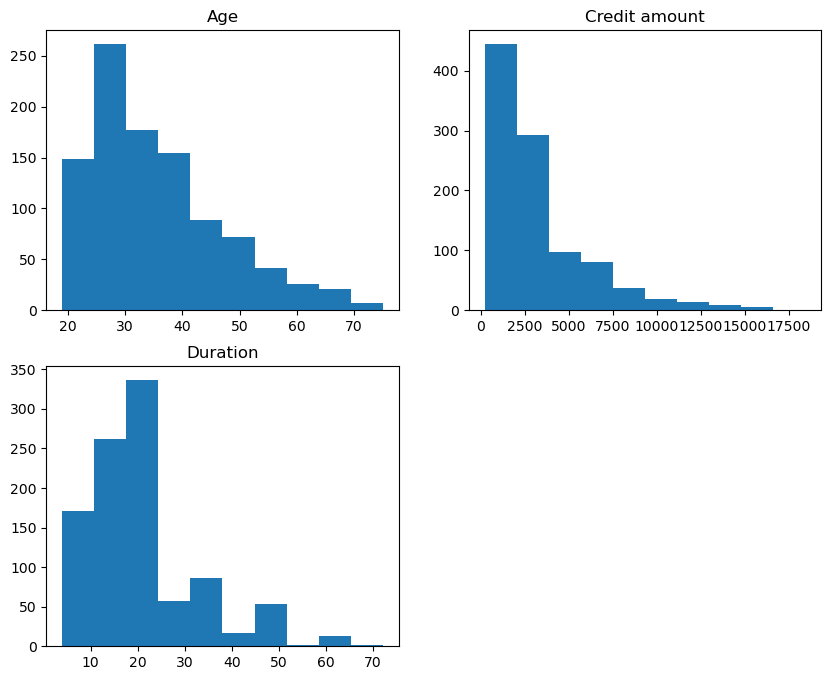

In [11]:
numerical_credit = credit.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in zip(range(len(cols)), cols):
    k += 1
    plt.subplot(2, 2, k)
    plt.hist(numerical_credit.iloc[:, i])
    plt.title(j)
plt.show()

In [43]:
scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)
scaled_credit = pd.DataFrame(scaled_credit, columns=numerical_credit.columns)

non_numerical_credit = credit.select_dtypes(include=['object'])
dummies_credit = pd.get_dummies(non_numerical_credit, drop_first=True)
dummies_credit = dummies_credit.astype(int)
dummies_credit['Risk'] = dummies_credit['Risk_good'].replace({1: 0, 0: 1})
del dummies_credit['Risk_good']
print(dummies_credit)

combined_credit = pd.concat([scaled_credit, dummies_credit], axis=1)
print(combined_credit)

     Sex_male  Job_skilled  Job_unskilled and non-resident  \
0           1            1                               0   
1           0            1                               0   
2           1            0                               0   
3           1            1                               0   
4           1            1                               0   
..        ...          ...                             ...   
995         0            0                               0   
996         1            0                               0   
997         1            1                               0   
998         1            1                               0   
999         1            1                               0   

     Job_unskilled and residen  Housing_own  Housing_rent  \
0                            0            1             0   
1                            0            1             0   
2                            1            1             0   
3          

### Train test split

In [46]:
X = combined_credit.drop("Risk", axis=1)
y = combined_credit["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression Model

Intercept:  -0.012227561610524506
area under ROC curve is  0.5906959971150378


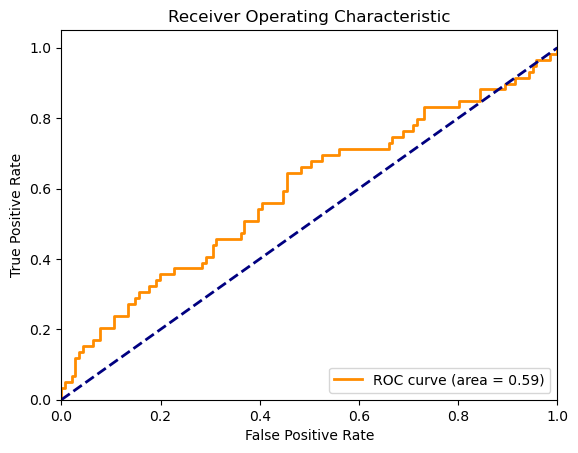

In [47]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
coefficients = logistic_regression.coef_
intercept = logistic_regression.intercept_
coef_df = pd.DataFrame(data=coefficients, columns=X_train.columns)
print("Intercept: ", intercept[0])

y_pred = logistic_regression.predict(X_test)
y_score = logistic_regression.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('area under ROC curve is ', roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machine

In [48]:
param_svc = {'gamma': [1e-6, 1e-2],
                 'C': [0.001, 0.09, 1, 5, 10],
                 'kernel': ['linear', 'rbf']}
svc = SVC(class_weight='balanced')
halve_SVC = HalvingRandomSearchCV(svc, param_svc, scoring='roc_auc', n_jobs=-1)
halve_SVC.fit(X_train, y_train)
y_pred_SVC = halve_SVC.predict(X_test)
print('The ROC AUC score of SVC is {:4f}'.format(roc_auc_score(y_test, y_pred_SVC)))

The ROC AUC score of SVC is 0.593881


### Random Forest 

In [49]:
rfc = RandomForestClassifier(random_state=42)

param_rfc = {'n_estimators': [100, 300],
            'criterion': ['gini', 'entropy'],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [5, 10]}

halve_RF = HalvingRandomSearchCV(rfc, param_rfc, scoring='roc_auc', n_jobs=-1)
halve_RF.fit(X_train, y_train)
y_pred_SVC = halve_RF.predict(X_test)
print('The ROC AUC score of RF is {:4f}'.format(roc_auc_score(y_test, y_pred_SVC)))

The ROC AUC score of RF is 0.508475
